# Predição de votação do Poder Legislativo

O objetivo deste lab é obter um modelo que preveja a votação de Deputados Federais, baseado em votações anteriores (2006 e 2010). Os modelos são postos à prova com dados da votação de 2014. Parte do processo é baseada no notebook [Regularized Linear Models](https://www.kaggle.com/apapiu/regularized-linear-models), de Alexandru Papiu.

### Análise descritiva dos dados

Para que se entenda a organização e distribuição dos dados, além de um primeiro tratamento de inconsistências, faz-se aqui uma análise descritiva simples, utilizando as bibliotecas `numpy` e `pandas`.

In [292]:
import pandas as pd
import numpy as np


# carregar datasets
data06 = pd.read_csv("eleicoes_2006.csv")
data10 = pd.read_csv("eleicoes_2010.csv")
data14 = pd.read_csv("eleicoes_2014.csv")

# juntar os dados de treino (06 + 10)
data = pd.concat((data06, data10, data14), sort=False)

Descrevendo o conjunto de dados: primeiro, colunas numéricas:

In [293]:
data.describe(include='number')

,ano,sequencial_candidato,quantidade_doacoes,quantidade_doadores,total_receita,media_receita,recursos_de_outros_candidatos/comites,recursos_de_pessoas_fisicas,recursos_de_pessoas_juridicas,recursos_proprios,quantidade_despesas,quantidade_fornecedores,total_despesa,media_despesa,votos
count,12266.00000,1.226600e+04,12266.000000,12266.000000,1.210500e+04,12105.000000,8.131000e+03,8.374000e+03,5.068000e+03,7.802000e+03,12266.000000,12266.000000,1.226600e+04,12266.000000,1.226600e+04
mean,2010.50481,1.215327e+11,26.901516,23.966004,1.732731e+05,5750.422579,3.138623e+04,3.888337e+04,1.854461e+05,4.076254e+04,139.323251,112.960134,1.774981e+05,1437.786337,2.079497e+04
std,3.25638,9.618308e+10,97.062103,84.253638,4.578935e+05,14174.233933,1.227336e+05,9.484481e+04,3.785514e+05,1.810289e+05,426.833979,342.131860,4.660459e+05,5062.045356,4.749302e+04
min,2006.00000,1.000100e+04,1.000000,1.000000,0.000000e+00,0.000000,1.500000e-01,1.000000e-02,0.000000e+00,0.000000e+00,1.000000,1.000000,0.000000e+00,0.000000,0.000000e+00
25%,2006.00000,1.194075e+04,4.000000,4.000000,2.838930e+03,614.428571,1.130000e+03,1.500000e+03,3.188675e+03,1.193635e+03,6.000000,5.000000,2.873425e+03,426.370839,6.850000e+02
50%,2010.00000,1.300000e+11,9.000000,8.000000,1.180013e+04,1490.308333,3.733890e+03,6.600000e+03,2.641750e+04,5.000000e+03,19.000000,17.000000,1.224470e+04,824.156949,2.394000e+03
75%,2014.00000,2.100000e+11,23.000000,21.000000,8.912620e+04,4635.384615,1.500000e+04,3.380516e+04,1.850000e+05,2.093750e+04,79.000000,67.000000,9.666275e+04,1547.546412,1.572600e+04
max,2014.00000,2.700000e+11,6997.000000,5800.000000,5.836140e+06,500180.000000,3.664205e+06,1.826762e+06,3.828338e+06,5.525600e+06,9932.000000,8359.000000,7.420179e+06,500177.000000,1.524361e+06


Agora, colunas categóricas:

In [294]:
data.describe(include='object')

,nome,uf,partido,cargo,sexo,grau,estado_civil,ocupacao
count,12266,12266,12266,12266,12266,12266,12266,12266
unique,10923,27,36,1,2,7,5,192
top,FRANCISCO LOPES DA SILVA,SP,PT,DEPUTADO FEDERAL,MASCULINO,SUPERIOR COMPLETO,CASADO(A),OUTROS
freq,4,2707,913,12266,9912,6962,7545,1470


Para fins de simplicidade, vamos analisar apenas atributos relacionados ao financiamento das campanhas, que são numéricos. Excluem-se, portanto, as variáveis categóricas, como nome e cargo. A variável-alvo, ``votos``, também será excluída (mas se preserva nos dataframes separados por ano).

In [295]:
# removendo a variável-alvo. Note-se que ela está
# mantida nos dataframes separados por ano.
data.drop(['votos'], axis=1, inplace=True)

# removendo variáveis categóricas do modelo.
data.drop(['nome'], axis=1, inplace=True)
data.drop(['uf'], axis=1, inplace=True)
data.drop(['partido'], axis=1, inplace=True)
data.drop(['cargo'], axis=1, inplace=True)
data.drop(['grau'], axis=1, inplace=True)
data.drop(['estado_civil'], axis=1, inplace=True)
data.drop(['ocupacao'], axis=1, inplace=True)
data.drop(['sexo'], axis=1, inplace=True)
data.drop(['sequencial_candidato'], axis=1, inplace=True)
data.drop(['ano'], axis=1, inplace=True)

Aplicamos a função `log(votos + 1)` em todos os atributos numéricos que estejam enviesados. Primeiro, calculamos o quão enviesados eles estão, aplicando `log(atributo + 1)` a todos cuja taxa exceda `0.75`:

In [296]:
from scipy.stats import skew


# recuperar todos os atributos numéricos para
atr_numericos = data.dtypes[data.dtypes != 'object'].index

# aplicar a função skew para avaliar o enviesamento das variáveis
atr_enviesados = data[atr_numericos].apply(lambda x: skew(x.dropna()))
# considere apenas os atributos cujo skew é superior a 0.75
atr_enviesados = atr_enviesados[atr_enviesados > 0.75]
atr_enviesados = atr_enviesados.index

# aplique log(atributo + 1) nos atributos enviesados
data[atr_enviesados] = np.log1p(data[atr_enviesados])

Como há muitas variáveis numéricas sem valor (`NA`) definido, substituam-se os valores indefinidos pelas médias das respectivas colunas:

In [297]:
data = data.fillna(data.mean())

### Modelos

Esta seção se dedica à construção e posterior comparação de modelos de predição. A comparação dos modelos será dada em termos do RMSE nos dados de teste (correspondentes à eleição de 2014): menor é melhor.

Primeiro, vamos analisar cada modelo com base nos dados de 2006 (treino) e 2010 (teste). A seguir, os melhores serão retreinados com dados de 2006 e 2010, para que se possa testá-los, por fim, com os dados de 2014.

Deste modo, vamos separar os dados por ano:

In [298]:
# calcular índices pros dados, para poder separá-los por ano.
idx_06 = data06.shape[0]
idx_10 = data10.shape[0]
idx_14 = data14.shape[0]

# criar as matrizes pro sklearn.
train = data[:idx_06]
test = data[idx_06:idx_06+idx_10]

y_train = data06.votos
y_test = data10.votos

Definam-se as seguintes funções para cálculo de RMSE, RMSE de validação cruzada e para exibir os gráficos de resíduo de cada modelo.

In [299]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score


def rmse_cv(model, X, y):
    """Calcula o RMSE de validação cruzada de dado modelo."""
    rmse= np.sqrt(-cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv = 5))
    return(rmse)


def calculate_rmse(model, X, y):
    """Calcula o RMSE de dado modelo."""
    predictions = model.predict(X)
    mse = mean_squared_error(y, predictions)
    return np.sqrt(mse)


def plot_residuals(model, X, y):
    """Exibe o gráfico de resíduos de dado modelo."""
    df = pd.DataFrame({
        "predictions": model.predict(X),
        "real": y
    })
    df["residuals"] = df["real"] - df["predictions"]
    df.plot(x="predictions", y="residuals", kind="scatter")

#### Regressão Linear

Primeiro, considere-se um modelo de regressão clássico. Serão analisadas variações com (Ridge e Lasso) e sem regularização.

**Sem regularização**

In [300]:
from sklearn.linear_model import LinearRegression


# instanciar e treinar o modelo.
model_linear = LinearRegression(fit_intercept=True)
model_linear.fit(train, y_train)

# calcular RMSE do treino.
rmse_training = calculate_rmse(model_linear, train, y_train)
print rmse_training

33698.66851611233


In [301]:
# calcular RMSE do teste.
rmse_test = calculate_rmse(model_linear, test, y_test)

print rmse_test

37812.29620675348


Como se pode observar, o modelo de Regressão Linear sem regularização obteve RMSE de ``33698.67``. Quando aplicamos o modelo nos dados de teste (2010), observamos um RMSE de ``37812.30``.

Os resíduos se comportam da seguinte forma:

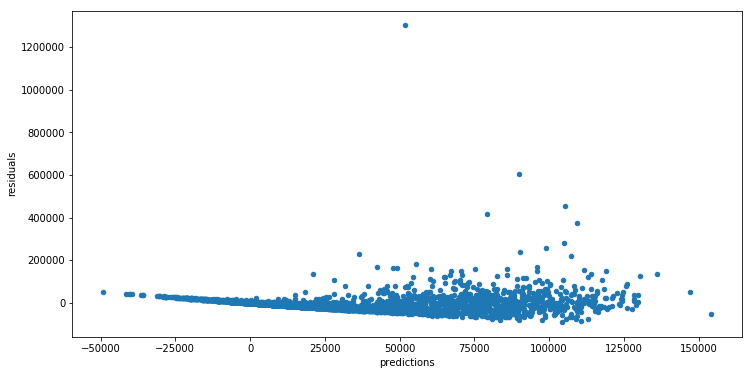

In [302]:
plot_residuals(model_linear, test, y_test)

**Com regularização: Ridge**

Primeiro precisa-se descobrir o alpha que melhor se aplica aos dados de treino:

In [303]:
from sklearn.linear_model import Ridge, RidgeCV


# descobrir qual o melhor alpha para o modelo.
alphas = [0.05, 0.1, 0.3, 1, 3, 5, 10, 15, 30, 50, 75]
cv_ridge_train = [rmse_cv(Ridge(alpha=alpha), train, y_train).mean() for alpha in alphas]
print min(cv_ridge_train), alphas[cv_ridge_train.index(min(cv_ridge_train))]

33413.699474079585 1


O valor de ``alpha = 1`` é o que tem melhor desempenho nos dados de treino, com RMSE de ``33413.70`` (pouco melhor que o modelo de Regressão Linear sem regularização). Vamos, agora, aplicar esse modelo nos dados de teste (2010):

In [304]:
# instanciar e treinar modelo com o alpha que achamos
model_ridge = Ridge(alpha=1)
model_ridge.fit(train, y_train)

# calcular RMSE nos dados de teste
print rmse_cv(model_ridge, test, y_test).mean()

36005.64967008875


Observa-se que o RMSE nos dados de teste foi de ``36005.65``, consideravelmente melhor que o modelo de Regressão Linear sem regularização.

Os resíduos se comportam da seguinte forma:

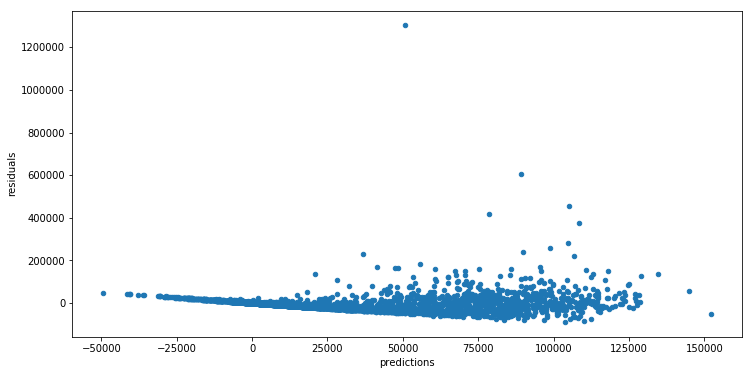

In [305]:
plot_residuals(model_ridge, test, y_test)

**Com regularização: Lasso**

Outro modelo de Regressão Linear com regularização é o Lasso. Aplicando-o nos dados de teste (2006):

In [306]:
from sklearn.linear_model import LassoCV, LassoLarsCV


model_lasso = LassoCV(alphas = [1, 0.1, 0.001, 0.0005]).fit(train, y_train)
print rmse_cv(model_lasso, train, y_train).mean()

33419.73501102944


In [307]:
print rmse_cv(model_lasso, test, y_test).mean()

36007.59185837375


Aplicando-o nos dados de teste (2006), temos um RMSE de ``33419.73``. Aplicando-o nos dados de treino (2010), o valor do RMSE sobe para ``36007.59``, resultado bem próximo do modelo anterior (Ridge).

Os resíduos se comportam da seguinte forma:

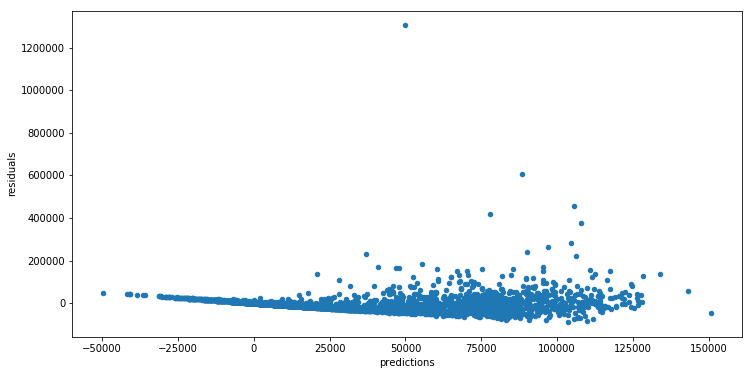

In [308]:
plot_residuals(model_lasso, test, y_test)

#### K-NN

Considere-se agora um modelo de regressão não-paramétrica, o K-NN (_K-nearest neighbours_).

Primeiro é preciso descobrir o valor ideal de _neighbors_ para obter o menor erro. Por razões de limitação computacional, vamos comparar apenas valores de 1 a 100:

In [309]:
from sklearn.neighbors import KNeighborsRegressor


def run_knn(X, y):
    rmses = []
    
    for K in range(100):
        K = K+1
        model_knn = KNeighborsRegressor(n_neighbors=K)
        model_knn.fit(X, y)
        
        e = rmse_cv(model_knn, X, y)
        rmses.append(e.mean())
        
    print min(rmses), rmses.index(min(rmses))
    return rmses

In [310]:
knn_train = run_knn(train, y_train)

30720.755004159397 26


Os números acima evidenciam que o modelo K-NN mais preciso tem 26 _neighbors_, com RMSE de ``30720.75``, o menor visto até agora.

Para aplicá-lo nos dados de teste, vamos instanciar o modelo e retreiná-lo, para depois aplicá-lo nos dados de teste:

In [311]:
model_knn = KNeighborsRegressor(n_neighbors=26)
model_knn.fit(train, y_train)

print rmse_cv(model_knn, test, y_test).mean()

33589.18247056067


O modelo K-NN aplicado nos dados de teste teve RMSE de ``33589.18``, também o menor visto até agora.

Os resíduos se comportam da seguinte forma:

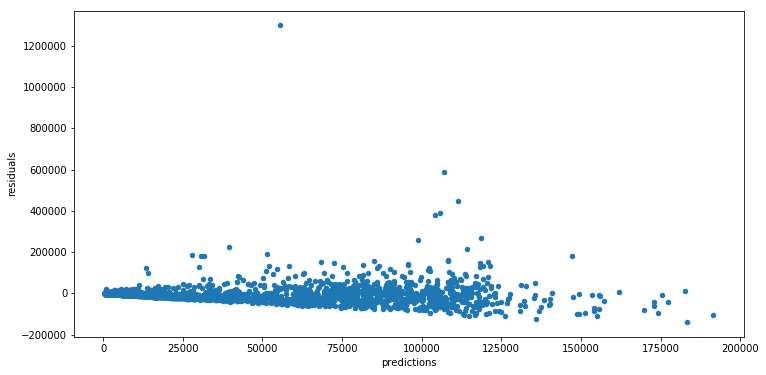

In [312]:
plot_residuals(model_knn, test, y_test)

#### Random Forests

Para complementar a nossa análise, também consderaremos um modelo mais elaborado, como o Random Forest.

Iniciamos por descobrir o número ideal de estimadores para nosso conjunto de teste. Novamente, por limitação computacional, só compararemos as análises com estimadores variando de 1 a 50.

In [326]:
from sklearn.ensemble import RandomForestRegressor


def run_rf(X, y):
    rmses = []
    
    for n in range(1, 50):
        try:
            del model_rf
        except UnboundLocalError:
            pass
        
        model_rf = RandomForestRegressor(n_estimators=n)
        model_rf.fit(X, y)
        
        e = rmse_cv(model_rf, X, y)
        rmses.append(e.mean())
        
    print min(rmses), rmses.index(min(rmses)) + 1
    return rmses

In [327]:
rf_train = run_rf(train, y_train)

32293.44505581355 23


Os números acima evidenciam que o modelo Random Forest mais preciso tem 23 estimadores, com RMSE de ``32293.44``.

Para aplicá-lo nos dados de teste, vamos instanciar o modelo e retreiná-lo, para depois aplicá-lo nos dados de teste:

In [328]:
model_rf = RandomForestRegressor(n_estimators=23)
model_rf.fit(train, y_train)

print rmse_cv(model_rf, test, y_test).mean()

37972.02525715475


_Oh well_. O modelo, quando aplicado aos dados de teste (2010), teve RMSE de ``373972.02``.

Os resíduos se comportam da seguinte forma:

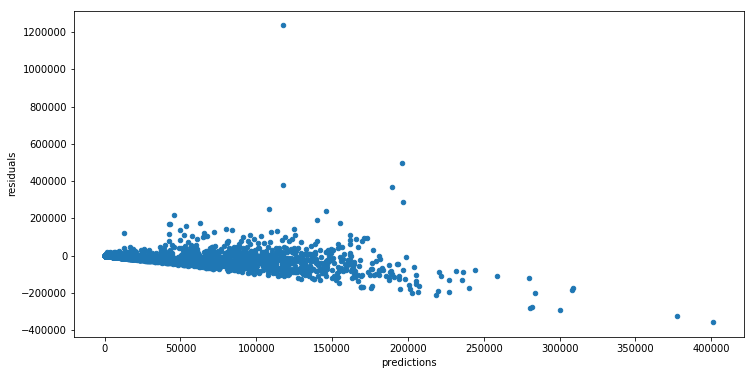

In [329]:
plot_residuals(model_rf, test, y_test)

### Validação final: dados de 2014

Os melhores resultados foram obtidos pelo modelo K-NN. Nesta seção avaliaremos o desempenho deste modelo com os dados de teste finais, relativos à votação de 2014. Também analisaremos os demais modelos brevemente.

Primeiro, vamos redefinir as matrizes que alimentarão os modelos: agora, nosso conjunto de treino é composto pelos dados de 2006 e 2010, enquanto o conjunto de teste é composto pelos dados de 2014:

In [331]:
train = data[:idx_06+idx_10]
test = data[idx_06+idx_10:]

y_train = pd.concat((data06.votos, data10.votos), sort=False)
y_test = data14.votos

Utilizando o modelo K-NN já instanciado e treinado, vamos retreiná-lo com os novos dados de treino (e calcular seu novo RMSE):

In [332]:
model_knn.fit(train, y_train)
print rmse_cv(model_knn, train, y_train).mean()

33071.125929482005


O novo RMSE para o conjunto de treino foi de ``33071.12``. Aplicando o modelo no conjunto de testes:

In [333]:
print rmse_cv(model_knn, test, y_test).mean()

31386.806690391


Obtém-se um RMSE de ``31386.81``. Isso significa dizer que o erro médio na predição do modelo é de aproximadamente 31,5 mil votos.

Os resíduos se comportam da seguinte forma:

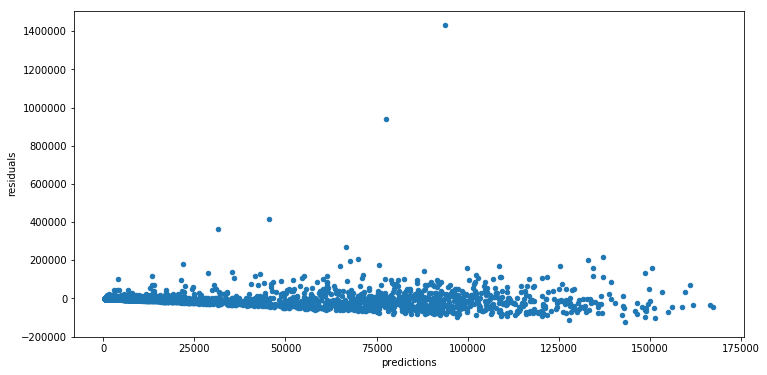

In [334]:
plot_residuals(model_knn, test, y_test)

#### Demais modelos

Vamos também analisar os RMSEs dos modelos de Regressão Linear/Ridge e Random Forest, para efeito de comparação, com os novos conjuntos de treino e teste.

In [336]:
# Ridge
model_ridge.fit(train, y_train)
print rmse_cv(model_ridge, test, y_test).mean()

33432.16172416216


In [338]:
# Random Forest
model_rf.fit(train, y_train)
print rmse_cv(model_rf, test, y_test).mean()

34334.40812839303


Mantendo a tendência da primeira comparação, os modelos tiveram desempenho inferior novamente. O modelo Ridge teve um RMSE de ``33432.16``, enquanto o Random Forest teve RMSE de ``34334.41``, com 23 estimadores.

### Conclusão

O modelo que melhor se saiu foi o K-NN, com RMSE de ``31386.81`` para 26 _neighbors_.

É importante observar, no entanto, que um erro médio de aproximadamente 31,5 mil votos é bastante significativo, já que essa quantidade de votos geralmente é decisiva numa disputa para Deputado Federal.